# Hodking-Huxley Model 

IPythone notebook created to document implementation of HH Model. 



In [1]:
#Setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Constants
C_m  =   0.5 #membrane capacitance, in uF/cm^2
g_Na = 120.0 #maximum conducances, in mS/cm^2
g_K  =  36.0
g_L  =   0.3
E_Na =  50.0    #Nernst reversal potentials, in mV
E_K  = -77.0
E_L = -54.387


## Steady states probabilties

In [2]:
##non-linear paramiters alfa and beta
def alpha_m(u): return (2.5 - 0.1 * (u + 65)) / (np.exp(2.5 - 0.1 * (u + 65)) - 1)
def alpha_n(u): return (0.1 - 0.01 * (u + 65)) / (np.exp(1 - 0.1 * (u + 65)) - 1)
def alpha_h(u): return (0.07 * np.exp((-u - 65) / 20))
def beta_m(u):  return 4 * np.exp((-u - 65) / 18)
def beta_n(u):  return 0.125 * np.exp((-u - 65) / 80)
def beta_h(u):  return 1 / (np.exp(3 - 0.1 * (u + 65)) + 1)

#compute steady state values - system specification
def MSS(u): return alpha_m(u) / (alpha_m(u) + beta_m(u))
def NSS(u): return alpha_n(u) / (alpha_n(u) + beta_n(u))
def HSS(u): return alpha_h(u) / (alpha_h(u) + beta_h(u))


/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


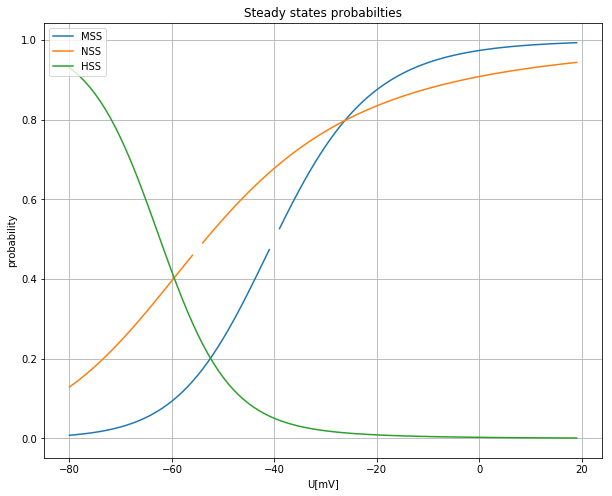

In [3]:
u = np.arange(-80, 20)

fig, ax = plt.subplots()
ax.plot(u, MSS(u), label="MSS")
ax.plot(u, NSS(u), label="NSS")
ax.plot(u, HSS(u), label="HSS")
ax.grid(True)
ax.legend(loc=2); # upper left corner
ax.set_xlabel('U[mV]')
ax.set_ylabel('probability')
ax.set_title('Steady states probabilties');


## Gating voltage and parameters changes

Calculation of membrane currents, partial derivatie calculations of parameters m,n,h and value of potential. Plots showing parameters behaviour after adding voltage from -65 mV(resting state) to +20 mV.

In [4]:
#Membrane currents
def INa(u, m, h): return g_Na * m**3 * h * (u - E_Na)  #sodium channel
def IK (u, n   ): return g_K  * n**4     * (u - E_K)   #potas
def IL (u      ): return g_L             * (u - E_L)

# F: < m,n,h>
def dm_du(m, u): return alpha_m(u) * (1 - m) - beta_m(u) * m
def dn_du(n, u): return alpha_n(u) * (1 - n) - beta_n(u) * n
def dh_du(h, u): return alpha_h(u) * (1 - h) - beta_h(u) * h
def du_du(u, m, n, h, I=0): return I - INa(u, m, h)- IK(u, n)- IL(u)/ C_m

#starting points - values of gating variables (MSS etc. when u = 0)
dt = 1e-3
u0 = -65   #membrane with fixed voltage
time_vec = np.arange(0, 50, dt)

M = np.zeros_like(time_vec)
N = np.zeros_like(time_vec)
H = np.zeros_like(time_vec)
U = np.ones_like(time_vec) * u0
dU = np.zeros_like(time_vec)

U[time_vec >= 10] = 20
M[0] = MSS(U[0])
N[0] = NSS(U[0])
H[0] = HSS(U[0])
dU[0] = U[0]

#evolution of state values over time
for t in range(0, len(time_vec)-1):
    M[t+1]  = M[t] + dm_du(M[t], U[t]) * dt
    N[t+1]  = N[t] + dn_du(N[t], U[t]) * dt
    H[t+1]  = H[t] + dh_du(H[t], U[t]) * dt
    dU[t+1] = U[t] + du_du(U[t], M[t+1], N[t+1], H[t+1]) * dt


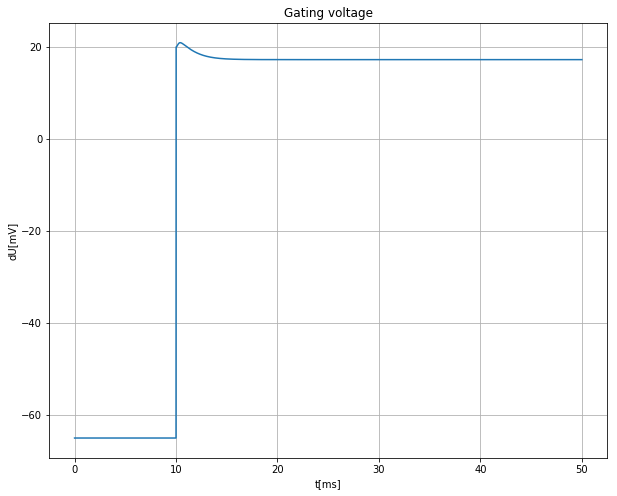

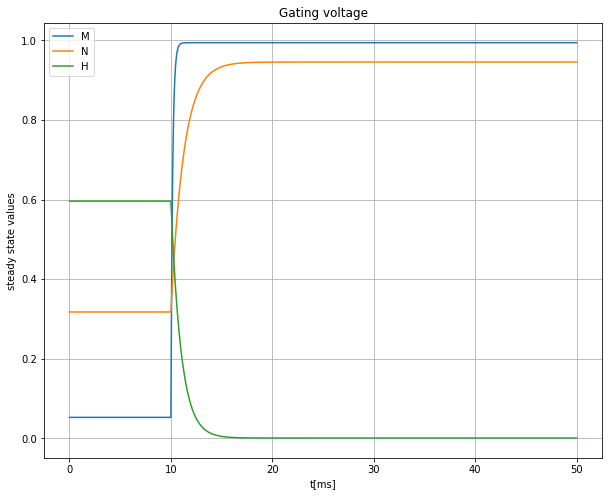

In [5]:
#Gating voltage plot
fig3, ax3 = plt.subplots()
ax3.plot(time_vec, dU, label="U")
ax3.grid(True)
ax3.set_xlabel('t[ms]')
ax3.set_ylabel('dU[mV]')
ax3.set_title('Gating voltage');

#steady states changes over time(dt)
fig2, ax2 = plt.subplots()
ax2.plot(time_vec, M, label="M")
ax2.plot(time_vec, N, label="N")
ax2.plot(time_vec, H, label="H")
ax2.grid(True)
ax2.legend(loc=2); # upper left corner
ax2.set_xlabel('t[ms]')
ax2.set_ylabel('steady state values')
ax2.set_title('Gating voltage');


## Conductances

In [6]:
#conducances model
def cond_Na(m, h): return g_Na * m**3 * h
def cond_K (n   ): return g_K  * n**4


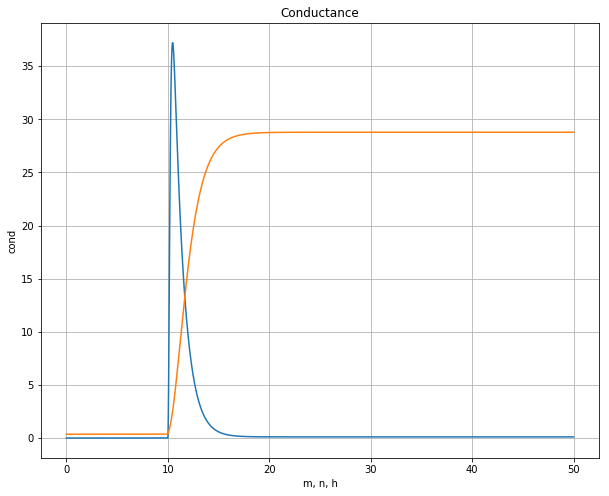

In [7]:
#Conductance plot
fig4, ax4 = plt.subplots()
ax4.plot(time_vec, cond_Na(M, H), label="cNa")
ax4.plot(time_vec, cond_K(N)    , label="cK ")
ax4.grid(True)
ax4.set_xlabel('m, n, h')
ax4.set_ylabel('cond')
ax4.set_title('Conductance');

plt.show()